In [1]:

import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import os
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Import necessary libraries
import tensorflow as tf
import numpy as np

# Set the path to the directory containing the dataset
data_dir = "./dataset"

# Load images from the dataset directory and create a TensorFlow dataset
# Images are resized to 128x128 pixels and grouped into batches of size 32
# Labels are one-hot encoded using categorical mode
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir, image_size=(128, 128), batch_size=32, label_mode="categorical"
)

# Define the training data split ratio
train_size = 0.8

# Split the dataset into training and testing subsets
# `take` is used to select the first `train_size` fraction of the dataset
train_ds = dataset.take(int(len(dataset) * train_size))

# `skip` is used to exclude the first `train_size` fraction, creating the test dataset
test_ds = dataset.skip(int(len(dataset) * train_size))

# Define a helper function to convert a dataset into NumPy arrays
def dataset_to_numpy(dataset):
    images, labels = [], []
    for batch_images, batch_labels in dataset:
        # Append images and labels from each batch to lists
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    # Concatenate all batches into single NumPy arrays for images and labels
    return np.concatenate(images), np.concatenate(labels)

# Convert the training and testing datasets into NumPy arrays
x_train, y_train = dataset_to_numpy(train_ds)
x_test, y_test = dataset_to_numpy(test_ds)

# Normalize the image pixel values to the range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Optimize dataset performance by prefetching batches in the background
# Prefetching helps reduce input pipeline bottlenecks
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 19750 files belonging to 17 classes.


In [3]:


# Apply data augmentation on the training data
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the image pixels to [0,1]
    rotation_range=20,  # Rotate images
    width_shift_range=0.2,  # Shift images horizontally
    height_shift_range=0.2,  # Shift images vertically
    shear_range=0.2,  # Shear images
    zoom_range=0.2,  # Zoom in or out
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode="nearest"  # Fill in pixels after transformations
)

train_ds = datagen.flow(x_train, y_train, batch_size=64)


In [4]:
# Define Model Path
model_path = "saved_model.h5"  # Change this path if needed

In [5]:

# Load the pre-trained EfficientNet model without the top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
base_model.trainable = False


In [6]:

# Check if a pre-trained model already exists
if os.path.exists(model_path):  # `model_path` is the path to the saved model file
    print("Loading previously trained model...")
    # Load the pre-trained model from the specified path
    model = load_model(model_path)
else:
    print("Creating a new model...")
    # Create a new Convolutional Neural Network (CNN) model using Sequential API
    model = Sequential([
        # First convolutional layer with 32 filters, 3x3 kernel size, and ReLU activation
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        # First max-pooling layer with 2x2 pool size to reduce spatial dimensions
        MaxPooling2D((2, 2)),
        
        # Second convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
        Conv2D(64, (3, 3), activation='relu'),
        # Second max-pooling layer with 2x2 pool size
        MaxPooling2D((2, 2)),
        
        # Third convolutional layer with 128 filters, 3x3 kernel size, and ReLU activation
        Conv2D(128, (3, 3), activation='relu'),
        # Third max-pooling layer with 2x2 pool size
        MaxPooling2D((2, 2)),
        
        # Flatten the feature maps into a 1D vector to feed into the dense layers
        Flatten(),
        # Fully connected (dense) layer with 512 neurons and ReLU activation
        Dense(512, activation='relu'),
        # Dropout layer to reduce overfitting (drops 50% of the neurons during training)
        Dropout(0.5),
        # Output layer with 17 neurons (one for each class) and softmax activation for classification
        Dense(17, activation='softmax')
    ])



Creating a new model...


c:\Users\bharg\garuda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:

# Define the optimizer for training the model
# Using the Adam optimizer with a learning rate of 0.001
# Adam combines the benefits of RMSProp and momentum for adaptive learning rates
optim = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model to configure the training process
model.compile(
    loss='categorical_crossentropy',  # Loss function for multi-class classification problems
    optimizer=optim,                 # Use the Adam optimizer defined above
    metrics=['accuracy']             # Monitor accuracy during training and evaluation
)

In [8]:
# Train the model on the training data
model.fit(
    x_train,             # Training data (features)
    y_train,             # Training labels (one-hot encoded)
    epochs=10,           # Number of complete passes through the entire dataset
    batch_size=64        # Number of samples per gradient update (processed in one batch)
)

Epoch 1/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 121s 480ms/step - accuracy: 0.1757 - loss: 2.6104
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 117s 471ms/step - accuracy: 0.3665 - loss: 2.0213
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 120s 487ms/step - accuracy: 0.4306 - loss: 1.7889
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 115s 463ms/step - accuracy: 0.4741 - loss: 1.6501
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 115s 466ms/step - accuracy: 0.5492 - loss: 1.3991
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 116s 469ms/step - accuracy: 0.6174 - loss: 1.2062
Epoch 7/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 123s 497ms/step - accuracy: 0.6919 - loss: 0.9483
Epoch 8/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 151s 610ms/step - accuracy: 0.7672 - loss: 0.7307
Epoch 9/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 151s 611ms/step - accuracy: 0.8147 - loss: 0.5730
Epoch 10/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 130s 527ms/step - accuracy: 0.8486 - loss: 0.4571


In [9]:
#  Save the Model after Training
model.save(model_path)  # Save the trained model to the specified path
print(f"Model saved at {model_path}")

Model saved at saved_model.h5


In [10]:
model = load_model('saved_model.h5')
# Evaluate the trained model on the test dataset
# Returns the loss value and any metrics specified during model compilation
model.evaluate(
    x_test,  # Test data (features)
    y_test   # Test labels (one-hot encoded)
)

124/124 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.5565 - loss: 1.9226


[2.0447006225585938, 0.5299340486526489]

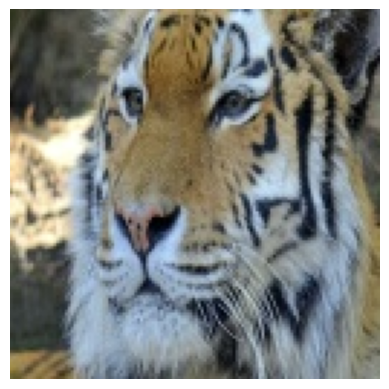

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted class: tiger
Actual class: tiger


In [14]:
class_names = dataset.class_names

# Pick a random image from the test set for prediction
idx = random.randint(0, len(x_test) - 1)
test_image = x_test[idx]
true_class_idx = np.argmax(y_test[idx])  # True class index
true_class_name = class_names[true_class_idx]

plt.imshow(test_image)
plt.axis('off')  # Hide axis for a cleaner view
# plt.title(f"Actual: {true_class_name}")
plt.show()

# Predict the class for the test image
predicted_prob = model.predict(test_image.reshape(1, 128,128, 3))  # Reshape the image
predicted_class_idx = np.argmax(predicted_prob)  # Get the predicted class index
predicted_class_name = class_names[predicted_class_idx]

# Display predicted and actual class names
print(f"Predicted class: {predicted_class_name}")
print(f"Actual class: {true_class_name}")

In [12]:
# Define the threat levels for each class of animal
class_threat_levels = {
    'bear': 'High',
    'boar': 'Medium',
    'elephant': 'Medium',
    'cow': 'Low',
    'goat': 'Low',
    'sheep': 'Low',
    'lion': 'High',
    'tiger': 'High',
    'cheetah': 'Medium',
    'wolf': 'Medium',
    'giraffe': 'Low',
    'leopard': 'High',
    'deer': 'Low',
    'rhinoceros': 'High',
    'gorilla': 'Medium',
    'monkey': 'Low',
    'horse': 'Low'
}

In [13]:

# import requests

# def send_sms_via_fast2sms(message, phone_number):
#     """
#     Sends an SMS using Fast2SMS API.

#     Args:
#         message (str): The text message to send.
#         phone_number (str): The recipient's phone number (10-digit Indian number).
#     """
#     # Define the Fast2SMS API URL
#     url = "https://www.fast2sms.com/dev/bulkV2"
    
#     # Set the necessary headers for the request, including the API key
#     headers = {
#         'authorization': '........',  # Replace with your Fast2SMS API key
#         'Content-Type': 'application/x-www-form-urlencoded'  # Set content type to URL encoded form data
#     }
    
#     # Define the payload (data) for the SMS request
#     # `sender_id`: The sender ID that appears on the recipient's phone
#     # `message`: The content of the message to send
#     # `route`: 'q' is used for transactional messages
#     # `numbers`: The recipient's phone number(s) in comma-separated format
#     payload = {
#         'sender_id': 'FSTSMS',  # Default sender ID for Fast2SMS
#         'message': message,     # The message passed as an argument
#         'route': 'q',           # 'q' is for transactional messages
#         'numbers': phone_number # Recipient's phone number (replace with actual number)
#     }
    
#     # Send the POST request to the Fast2SMS API with the given headers and payload
#     response = requests.post(url, headers=headers, data=payload)
    
#     # Parse the JSON response from the API
#     response_json = response.json()
    
#     # Check if the message was sent successfully by looking at the 'return' key in the response
#     if response_json.get("return"):
#         print("Message sent successfully!")  # Success message
#     else:
#         # If sending the message fails, print the error message from the response
#         print(f"Failed to send message: {response_json.get('message')}")

# # Prepare the message to send
# # Here, `predicted_class_name` and `predicted_threat_level` are assumed to be defined elsewhere in the code
# sms_message = f"Prediction: {predicted_class_name.capitalize()} - Threat Level: {predicted_threat_level}"

# # Call the function to send the SMS
# send_sms_via_fast2sms(sms_message, "1234567890")  # Replace with the recipient's phone number
